In [14]:
import numpy as np
from Function import LossFunctionTask2
from utils import generate_adj_matrix
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams["font.family"] = "cmr10"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["axes.formatter.use_mathtext"] = True
plt.rcParams["font.size"] = 20
plt.rcParams["legend.fontsize"] = 13

def plot_scenario(
    robots_pos: np.ndarray, private_targets: np.ndarray, old_robots_pos=None
):
    colors = [
        "tab:orange",
        "tab:purple",
        "tab:green",
        "tab:blue",
        "tab:cyan",
        "tab:red",
    ]
    barycenter = np.mean(robots_pos, axis=0)
    plt.plot(
        barycenter[0],
        barycenter[1],
        "s",
        color="tab:blue",
        label="Barycenter",
        markersize=20,
        alpha=0.75,
    )
    for i in range(len(robots_pos)):
        plt.plot(
            robots_pos[i][0],
            robots_pos[i][1],
            "o",
            color=colors[i % len(colors)],
            markersize=12,
        )

        # Draw small lines segment from robot to barycenter
        plt.plot(
            [robots_pos[i][0], barycenter[0]],
            [robots_pos[i][1], barycenter[1]],
            color=colors[i % len(colors)],
            linestyle="dashdot",
            alpha=0.2,
        )

    for i in range(len(private_targets)):
        plt.plot(
            private_targets[i][0],
            private_targets[i][1],
            "X",
            color=colors[i % len(colors)],
            label=f"Target {i}",
            markersize=8,
            alpha=0.75,
        )

    if old_robots_pos is not None:
        # Trace the path of the robots
        for i in range(len(robots_pos)):
            plt.plot(
                [old_robots_pos[j][i][0] for j in range(len(old_robots_pos))],
                [old_robots_pos[j][i][1] for j in range(len(old_robots_pos))],
                color=colors[i % len(colors)],
                linestyle="--",
                alpha=0.5,
            )

#############################
# PARAMETERS
#############################

NUM_ROBOTS = 5
VAR_DIMS = 2
SEED = 47
NUM_ITERATIONS = 5000
ALPHA = lambda k: 2e-3
GAMMAS = [0.1] * NUM_ROBOTS

rng = np.random.default_rng(SEED)

#############################
# PROBLEM SETUP
#############################

private_targets = rng.random(size=(NUM_ROBOTS, VAR_DIMS))
loss_functions = [
    LossFunctionTask2(private_targets[i], GAMMAS[i]) for i in range(NUM_ROBOTS)
]
robot_initial_positions = rng.random(size=(NUM_ROBOTS, VAR_DIMS))

G, A = generate_adj_matrix(
    NUM_ROBOTS,
    connected=True,
    seed=SEED,
    graph_algorithm="erdos_renyi",
    erdos_renyi_p=0.3,
)

def phi(x):
    return x


def grad_phi(x):
    return np.ones(x.shape[0])


def gradient_tracking_aggregative(
    fn_list: list[LossFunctionTask2],
    z0: np.ndarray,
    A: np.ndarray,
    alpha: callable,
    num_iters: int,
    num_agents: int,
    phi: callable = phi,
    grad_phi: callable = grad_phi,
    return_s_v: bool = False,
):
    z = np.zeros((num_iters + 1, z0.shape[0], z0.shape[1]))
    s = np.zeros((num_iters + 1, z0.shape[0], z0.shape[1]))
    v = np.zeros((num_iters + 1, z0.shape[0], z0.shape[1]))

    z[0] = z0
    s[0] = phi(z0)
    for i in range(num_agents):
        v[0] = fn_list[i].grad_sigma_z(z[0][i], s[0][i])

    for k in range(num_iters):
        for i in range(num_agents):
            neighbors = np.nonzero(A[i])[0]

            z[k + 1, i] = z[k, i] - alpha(k) * (
                fn_list[i].grad_z(z[k, i], s[k, i]) + v[k, i] * grad_phi(z[k, i])
            )
            s[k + 1, i] = sum(A[i, j] * s[k, j] for j in neighbors) + (
                phi(z[k + 1, i]) - phi(z[k, i])
            )
            v[k + 1, i] = sum(A[i, j] * v[k, j] for j in neighbors) + (
                fn_list[i].grad_sigma_z(z[k + 1, i], s[k + 1, i])
                - fn_list[i].grad_sigma_z(z[k, i], s[k, i])
            )

    if return_s_v:
        return z, s, v
    else:
        return z

z_history,s_history, v_history  = gradient_tracking_aggregative(
    fn_list=loss_functions,
    z0=robot_initial_positions.copy(),
    A=A,
    num_iters=NUM_ITERATIONS,
    alpha=ALPHA,
    return_s_v=True,
    num_agents=NUM_ROBOTS,
)

cost_history = [
    sum([loss_functions[i](z_i, np.mean(z)) for i, z_i in enumerate(z)])
    for z in z_history
]

grad_cost_history = np.array([
    [(
        loss_functions[i].grad_z(z[i], s[i]) + v[i] * grad_phi(z[i])
    ) 
    for i in range(NUM_ROBOTS)]
    for z,v,s in zip(z_history, v_history, s_history)
])
grad_cost_history_sum = np.linalg.norm(np.sum(grad_cost_history, axis=1), axis=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


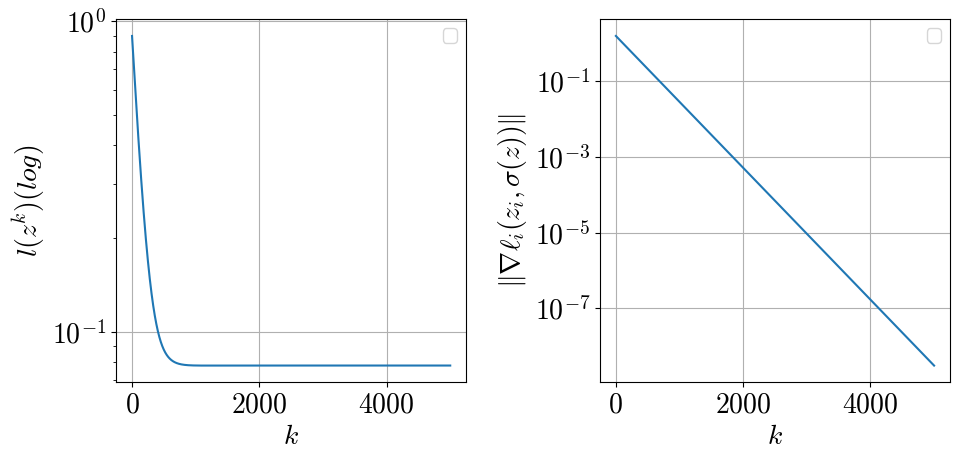

In [15]:
cost_history = [
    sum([loss_functions[i](z_i, np.mean(z)) for i, z_i in enumerate(z)])
    for z in z_history
]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cost_history)
plt.xlabel("$k$")
plt.ylabel("$l(z^k) (log)$")
plt.yscale("log")
plt.grid()
plt.legend()
plt.tight_layout()

plt.subplot(1, 2, 2)
grad_cost_history = np.array(
    [
        [
            (loss_functions[i].grad_z(z[i], s[i]) + v[i] * grad_phi(z[i]))
            for i in range(NUM_ROBOTS)
        ]
        for z, v, s in zip(
            z_history, v_history, s_history
        )
    ]
)
grad_cost_history_sum = np.linalg.norm(
    np.sum(grad_cost_history, axis=1), axis=1
)
plt.plot(grad_cost_history_sum)
plt.xlabel("$k$")
plt.ylabel(r"$\|\nabla \ell_i(z_i, \sigma(z))\|$")
plt.yscale("log")
plt.grid()
plt.legend()
plt.tight_layout()

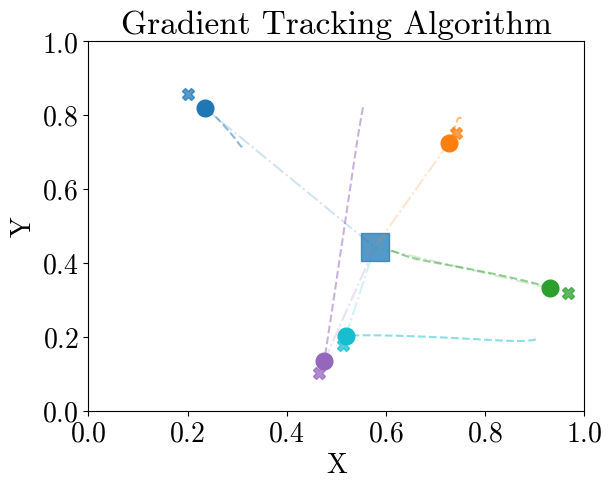

In [16]:
from IPython.display import HTML
# Create an animation, by showing the scenario at each iteration
def animate_scenario(z_history, private_targets, frames):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title("Gradient Tracking Algorithm")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # frames = range(0, 200, skip)

    def update(frame_idx):
        ax.clear()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title("Gradient Tracking Algorithm")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        plot_scenario(z_history[frames[frame_idx]], private_targets, z_history[:frames[frame_idx] + 1])
        return (ax,)

    ani = FuncAnimation(fig, update, frames=len(frames), blit=False, interval=200)

    # Fix: Display the animation
    display(HTML(ani.to_jshtml()))

    # Save the animation as a video file
    ani.save("gradient_tracking_animation.mp4", fps=10, extra_args=["-vcodec", "libx264"])
    # plt.show()

animate_scenario(z_history, private_targets, frames=range(0, 2000, 20))

In [21]:
plot_scenario(z_history[0], private_targets, z_history[0:0])
plt.grid()
plt.ylim([0,1])
plt.xlim([0,1])
plt.savefig("task_2.1_initial_scenario.pdf", bbox_inches='tight', dpi=300)
plt.close()

plot_scenario(z_history[-1], private_targets, z_history[:1000:20])
plt.grid()
plt.ylim([0,1])
plt.xlim([0,1])
plt.savefig("task_2.1_final_scenario.pdf", bbox_inches='tight', dpi=300)
plt.close()